In [1]:
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

from models.HAPDModel import HAPDModel
from utils.Result import Result

%reload_ext autoreload
%autoreload 2

from distfit import distfit

from utils.constants import *
from utils.real_time_adjustment_utils import *

 - 0 : down_imbalance
 - 1 : balance
 - 2 : up_imbalance

In [2]:
start_index = HOURS_PER_YEAR
training_length = HOURS_PER_MONTH
testing_length = HOURS_PER_DAY

In [3]:
dataframe = pd.read_csv('2022_2023/2022_2023_data.csv', index_col=0)
dataframe['price_diff'] = dataframe['prices_SB'] - dataframe['forward_RE']
dataframe['balancing_state'] = np.where(dataframe['price_diff'] > 0, 2, np.where(dataframe['price_diff'] < 0, 0, 1))
balancing_states = dataframe['balancing_state'].values
# Store in another array the duration of each state
durations = np.zeros_like(balancing_states)
# Print the first 10 states
print("States:\n")
print(balancing_states[:10])
display(dataframe.head(10))

States:

[1 1 1 1 1 1 1 0 0 0]


,forward_RE,forward_FC,prices_SB,production_RE,production_FC,Offshore DK2,Offshore DK1,Onshore DK2,Onshore DK1,price_diff,balancing_state
0,41.33,57.547726,41.33,0.995098,1.000000,0.274701,0.506045,0.680247,0.659599,0.00,1
1,42.18,42.775177,42.18,1.000000,1.000000,0.356135,0.541451,0.796296,0.671060,0.00,1
2,44.37,69.404847,44.37,1.000000,0.776486,0.279045,0.219344,0.728395,0.638109,0.00,1
3,37.67,39.025886,37.67,0.995098,0.935938,0.228013,0.201209,0.698765,0.619771,0.00,1
4,39.70,61.991515,39.70,1.000000,1.000000,0.221498,0.201209,0.690123,0.604011,0.00,1
5,40.59,39.462294,40.59,0.995098,0.986932,0.221498,0.201209,0.687654,0.613754,0.00,1
6,43.26,48.842056,43.26,0.995098,1.000000,0.221498,0.199482,0.719753,0.663897,0.00,1
7,49.66,48.002595,43.14,0.995098,0.964787,0.228013,0.201209,0.662963,0.652722,-6.52,0
8,70.05,66.866305,43.13,1.000000,1.000000,0.386536,0.199482,0.690123,0.651003,-26.92,0
9,76.79,77.209486,50.00,1.000000,0.803111,0.386536,0.195164,0.682716,0.755874,-26.79,0


In [4]:
states = ['down_imbalance','balance','up_imbalance']
num_states = len(states)

In [5]:
# Initialize the duration of the first state
def compute_durations(states):
    duration = 1
    durations = {0: [], 1: [], 2: []}
    # Iterate over the states to compute the duration of each state
    for i in range(1, len(states)):
        if states[i] == states[i - 1]:
            duration += 1
        else:
            durations[states[i - 1]].append(duration)
            duration = 1
    durations[states[-1]].append(duration)
    return durations

state_durations = compute_durations(balancing_states[:start_index])

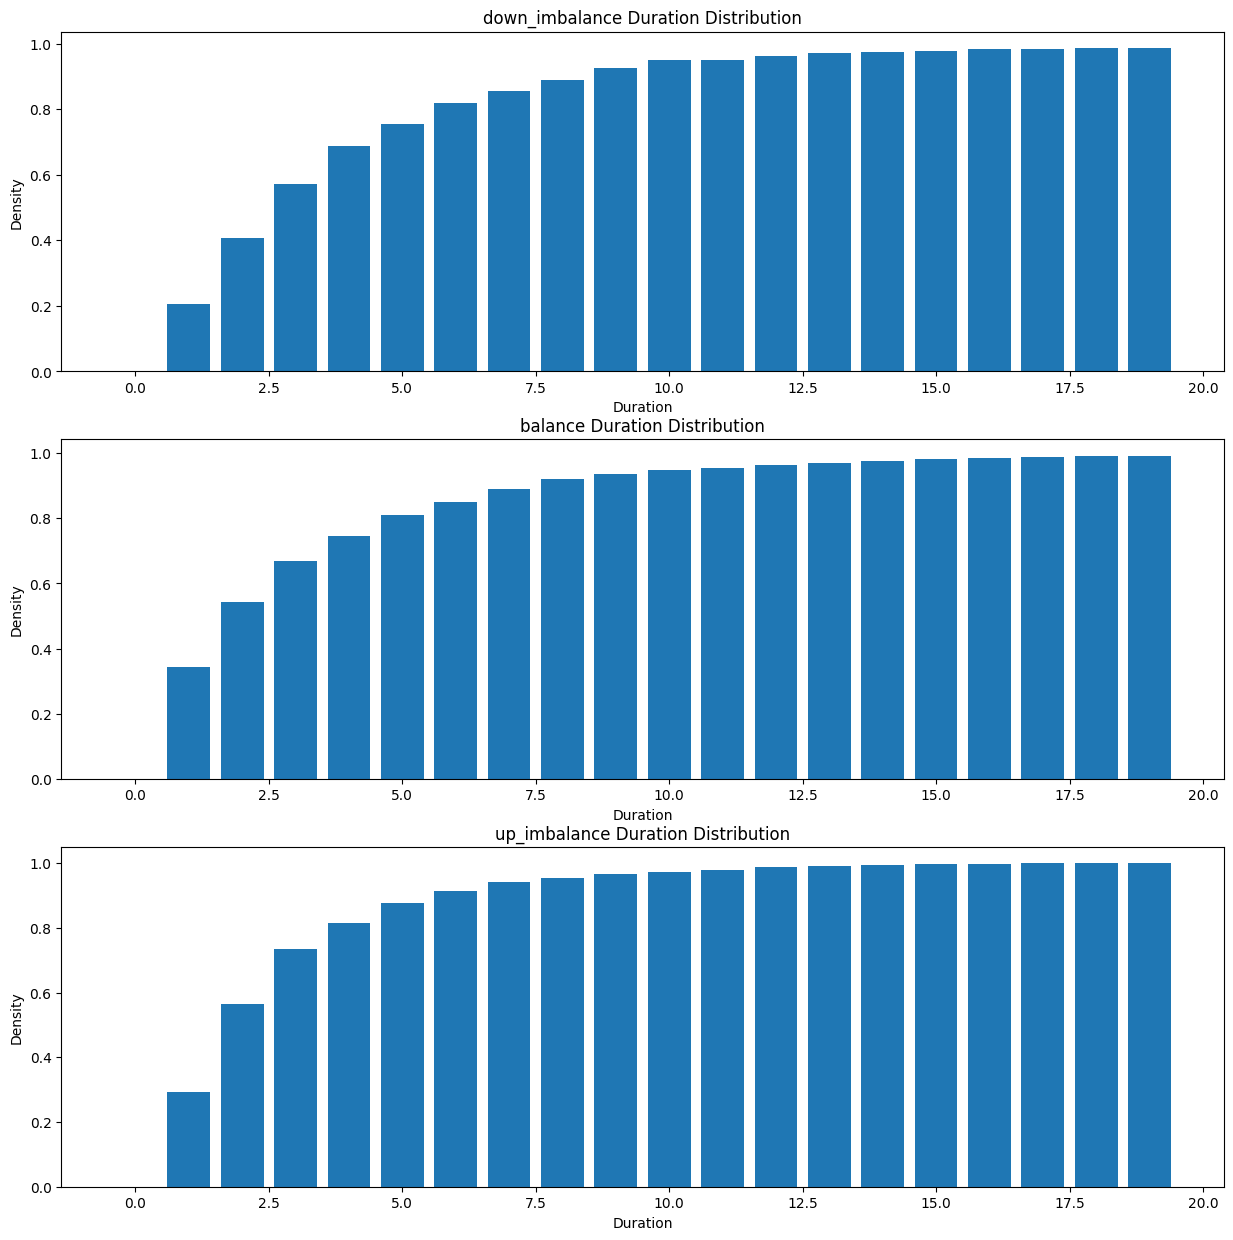

In [7]:
# Plot a bar plot with as x-axis 20 hours and as y-axis the density of times each state lasted at most the duration on the x-axis
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
duration_distribution = np.zeros((3, 20))
for state in range(3):
    aux = np.zeros(20)
    for duration in range(20):
        aux[duration] = np.sum(np.array(state_durations[state]) <= duration)
    aux /= len(state_durations[state])
    duration_distribution[state] = aux
    axs[state].bar(range(20), aux, label=states[state])
    axs[state].set_xlabel('Duration')
    axs[state].set_ylabel('Density')
    axs[state].set_title(f'{states[state]} Duration Distribution')
plt.show()

In [6]:
def build_hour_specific_transition_matrices(states,model_order=1):
    # Initialize a dictionary to store the count of transitions for each hour based on the model order
    transition_matrices = {hour: np.zeros((3,) * (model_order + 1), dtype=float) for hour in range(24)}
    # Count transitions based on the hour
    for i in range(model_order, len(states)):
        previous_states = tuple(states[i - model_order:i])
        current_state = states[i]
        transition_matrices[(i - 1) % 24][previous_states + (current_state,)] += 1
    # Normalize the count of transitions for each hour
    for hour, matrix in transition_matrices.items():
        # Iterate on all the possible previous states
        for previous_states in np.ndindex((3,) * model_order):
            # Normalize the count of transitions for each state
            transition_matrices[hour][previous_states] = (transition_matrices[hour][previous_states] / transition_matrices[hour][previous_states].sum()) if transition_matrices[hour][previous_states].sum() > 0 else np.ones(3) / 3
    return transition_matrices

In [7]:
# Generate a sequence of states based on the transition matrix
def generate_states(num_steps, initial_states, initial_hour, transition_matrices, model_order):
    if len(initial_states) < model_order:
        raise ValueError("Initial states length must be at least equal to the model_order")
    states = np.zeros(num_steps + model_order, dtype=int)
    states[:model_order] = initial_states
    hour = initial_hour

    for i in range(model_order, num_steps + model_order):
        previous_states = tuple(states[i - model_order:i])
        transition_probs = transition_matrices[hour][previous_states]
        states[i] = np.random.choice(3, p=transition_probs)
        hour = (hour + 1) % 24

    return states[model_order:]

def get_most_probable_states(num_steps, initial_states, initial_hour, transition_matrices, model_order):
    if len(initial_states) < model_order:
        raise ValueError("Initial states length must be at least equal to the model_order")
    states = np.zeros(num_steps + model_order, dtype=int)
    states[:model_order] = initial_states
    hour = initial_hour

    for i in range(model_order, num_steps + model_order):
        previous_states = tuple(states[i - model_order:i])
        transition_probs = transition_matrices[hour][previous_states]
        states[i] = np.argmax(transition_probs)
        hour = (hour + 1) % 24

    return states[model_order:]

In [8]:
# Example
model_order=1

transition_matrices_example = build_hour_specific_transition_matrices(balancing_states[:start_index],model_order=model_order)

print(f"Hour {0}:\n{transition_matrices_example[0]}\n")

Hour 0:
[[0.808      0.144      0.048     ]
 [0.14       0.76       0.1       ]
 [0.07058824 0.11764706 0.81176471]]



In [9]:
# Generate a sequence of states based on the transition matrix
num_steps = 24
current_state = balancing_states[start_index - model_order:start_index]
states = generate_states(num_steps, current_state, 0, transition_matrices_example, model_order=model_order)
print("Forecasted States:")
print(states)
print("Real States:")
print(balancing_states[start_index:start_index + num_steps])
print("\nAccuracy:", np.mean(states == balancing_states[start_index:start_index + num_steps]))

Forecasted States:
[0 0 1 2 2 2 2 2 2 2 2 1 0 0 0 0 0 0 0 0 1 1 2 2]
Real States:
[1 2 2 2 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0]

Accuracy: 0.3333333333333333


In [10]:
def test_markov_distribution(model_order):
    transition_matrices = build_hour_specific_transition_matrices(balancing_states[:start_index], model_order)
    num_steps = 100000
    states = generate_states(num_steps, balancing_states[start_index - model_order:start_index], 0, transition_matrices, model_order=model_order)
    durations = compute_durations(states)
    markov_duration_distribution = np.zeros((3, 20))
    # Plot a bar plot with as x-axis 20 hours and as y-axis the density of times each state lasted at most the duration on the x-axis
    for state in range(3):
        aux = np.zeros(20)
        for duration in range(20):
            aux[duration] = np.sum(np.array(durations[state]) <= duration)
        aux /= len(durations[state])
        markov_duration_distribution[state] = aux
        
    fig, axs = plt.subplots(3, 1, figsize=(15, 15))
    for state in range(3):
        axs[state].bar(range(20), duration_distribution[state], label='Real')
        axs[state].scatter(range(20), markov_duration_distribution[state],facecolors='none', label='Markov', edgecolors='red')
        axs[state].set_xlabel('Duration')
        axs[state].set_ylabel('Density')
        axs[state].legend()
        axs[state].set_title(f'{state} Duration Distribution')
    plt.show()

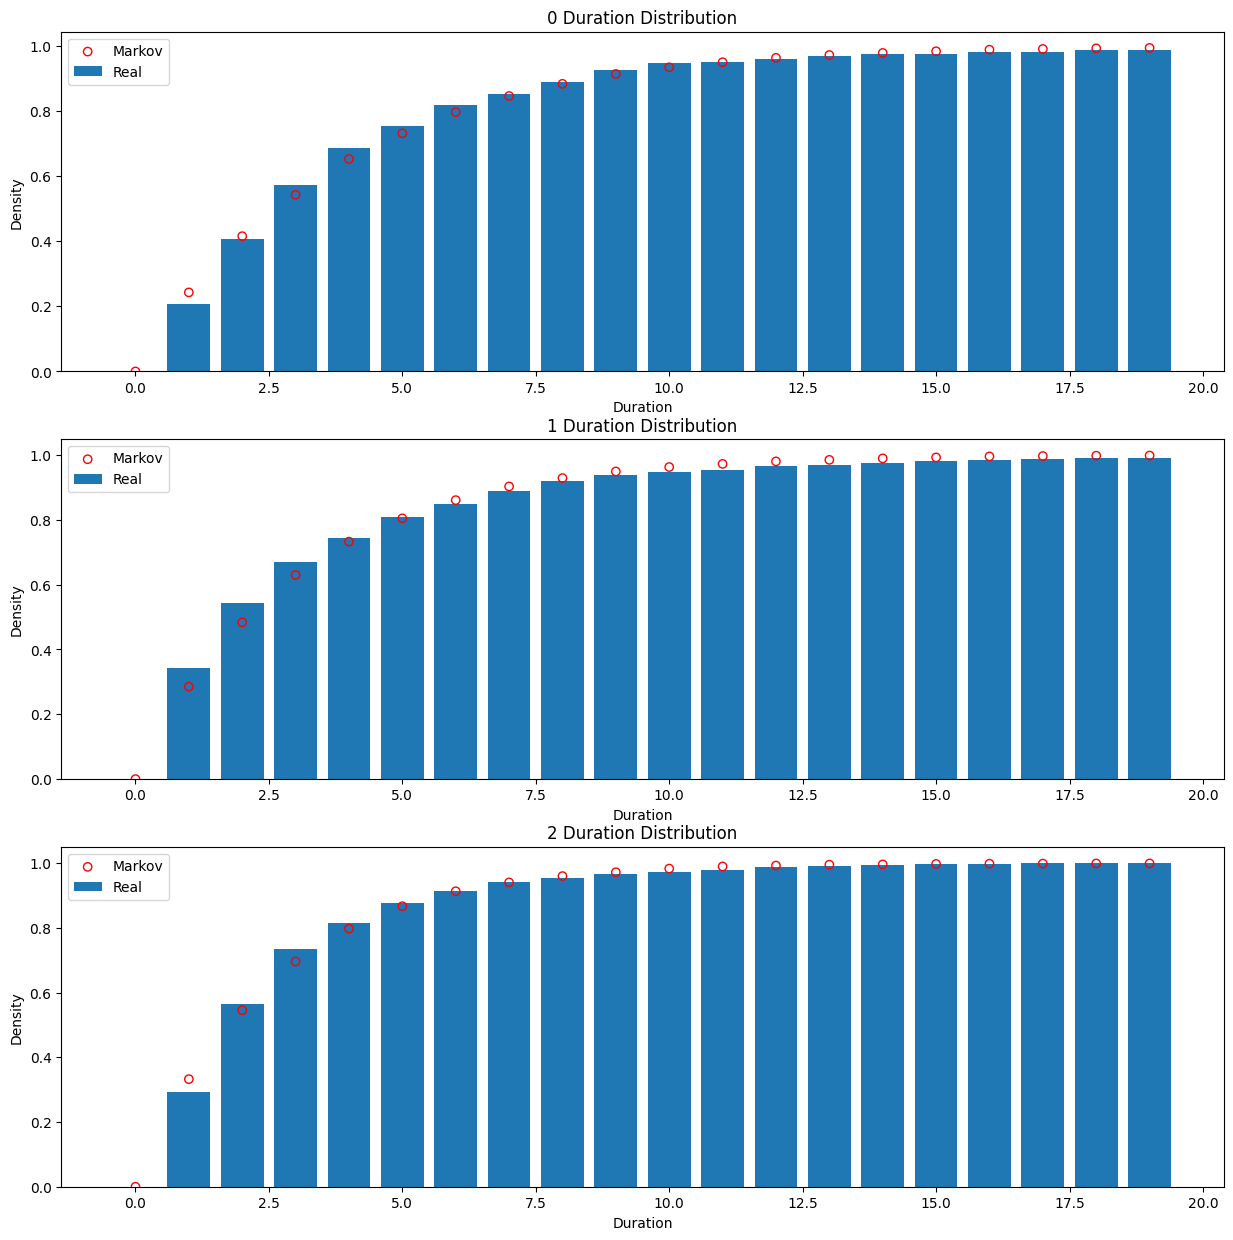

In [202]:
test_markov_distribution(1)

In [11]:
def find_most_similar_day_index(balancing_states_set,day_states):
    # Initialize the minimum distance and the index of the most similar day
    min_distance = np.inf
    most_similar_day_index = 0
    # Iterate over the days to find the most similar one
    for i in range(0,len(balancing_states_set)- HOURS_PER_DAY, HOURS_PER_DAY):
        states = balancing_states_set[i:i + 24]
        distance = np.sum(states != day_states)
        if distance < min_distance:
            min_distance = distance
            most_similar_day_index = i
    
    return most_similar_day_index

The most similar day is the one with the smallest Hamming distance to the previous day of the day we want to forecast.

We then use the day after the most similar day as the forecast.

CAREFUL: in this implementation, it returns the index of the most recent most similar day (if there are more than one). Maybe it is not such a bad idea to return the most similar day that is the closest to the day we want to forecast.

In [12]:
def find_most_similar_sequences_indexes(balancing_states_set, day_states,sequence_length):
    # Initialize the minimum distance and the index of the most similar day
    min_distance = np.inf
    most_similar_day_indexes = []
    
    if day_states.shape[0] != sequence_length:
        raise ValueError("The length of the day states should be equal to the sequence length.")

    # Iterate over the days to find the most similar one
    for i in range(0,len(balancing_states_set) - 2*HOURS_PER_DAY):
        states = balancing_states_set[i:i + sequence_length]
        distance = np.sum(states != day_states)
        if distance < min_distance:
            min_distance = distance
            most_similar_day_indexes = [i]
        elif distance == min_distance:
            most_similar_day_indexes.append(i)

    return most_similar_day_indexes

def compute_most_probable_similar_sequence_scenario(balancing_states_set, day_states,sequence_length):
    most_similar_day_indexes = find_most_similar_sequences_indexes(balancing_states_set, day_states,sequence_length)
    possible_scenarios = np.zeros((24, 3))
    # For each hour, count the number of times each state appeared in the day after the most similar days
    for i in range(24):
        for index in most_similar_day_indexes:
            possible_scenarios[i, balancing_states_set[index + 24 + i]] += 1
    # Return the most probable scenario
    return np.argmax(possible_scenarios, axis=1)

The most similar sequences are the ones with the smallest Hamming distance to the previous sequence of the day we want to forecast. Using this method with a sequence length of 24 hours corresponds to the most similar day.

Instead of returning the index of the most recent most similar sequence, we return all the indexes of the most similar sequences.

To compute the most probable similar sequence scenario, that will be our forecast, we count the number of times each state appeared in the day after the most similar sequences and return the most probable scenario.
 
#TODO: Try sampling from the underlying distribution of the most similar sequences to get a more robust forecast?

#TODO: It might be an interesting idea to ponderate the most similar sequences by their time distance to the day we want to forecast (the farther they are, the less they should be taken into account).

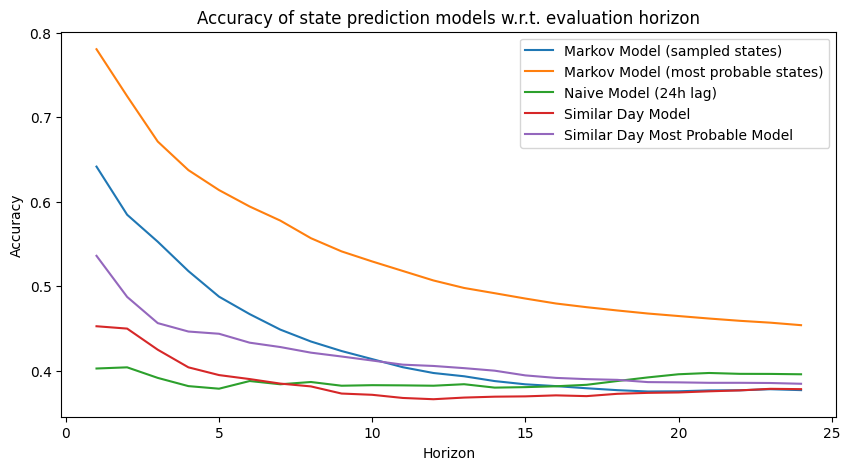

In [203]:
# Generate a very long sequence of states and plot the density of each state with duration inferior to the duration on the x-axis
num_steps = 24
model_order = 1
transition_matrices = build_hour_specific_transition_matrices(balancing_states[:start_index],model_order=model_order)
horizons = range(1,25)
accuracies = np.zeros((len(horizons), HOURS_PER_YEAR//num_steps))
accuracies_most_probable_states = np.zeros((len(horizons), HOURS_PER_YEAR//num_steps))
accuracies_lagged_values = np.zeros((len(horizons), HOURS_PER_YEAR//num_steps))
accuracies_similar_days = np.zeros((len(horizons), HOURS_PER_YEAR//num_steps))
accuracies_most_probable_similar_days = np.zeros((len(horizons), HOURS_PER_YEAR//num_steps))
for i in range(0,HOURS_PER_YEAR,num_steps):
    states = generate_states(num_steps, balancing_states[start_index - model_order + i:start_index + i], 0, transition_matrices, model_order)
    most_probable_states = get_most_probable_states(num_steps, balancing_states[start_index - model_order + i:start_index + i], 0, transition_matrices, model_order)
    lagged_states = balancing_states[(start_index + i - num_steps):(start_index + i)]
    # Find the most similar day
    most_similar_day = find_most_similar_day_index(balancing_states[:HOURS_PER_YEAR],balancing_states[start_index + i - num_steps:start_index + i])
    most_probable_similar_day = compute_most_probable_similar_sequence_scenario(balancing_states[:HOURS_PER_YEAR],balancing_states[start_index + i - num_steps:start_index + i], 24)
    similar_states = balancing_states[(most_similar_day + num_steps):(most_similar_day + 2*num_steps)]
    
    # Compute accuracy
    for j, horizon in enumerate(horizons):
        accuracy = np.mean(states[:horizon] == balancing_states[start_index + i:start_index + i + horizon])
        accuracy_most_probable_states = np.mean(most_probable_states[:horizon] == balancing_states[start_index + i:start_index + i + horizon])
        accuracy_lagged_values = np.mean(lagged_states[:horizon] == balancing_states[start_index + i:start_index + i + horizon])
        accuracy_similar_days = np.mean(similar_states[:horizon] == balancing_states[start_index + i:start_index + i + horizon])
        accuracy_most_probable_similar_days = np.mean(most_probable_similar_day[:horizon] == balancing_states[start_index + i:start_index + i + horizon])
        
        accuracies[j][i//num_steps] = accuracy
        accuracies_most_probable_states[j][i//num_steps] = accuracy_most_probable_states
        accuracies_lagged_values[j][i//num_steps] = accuracy_lagged_values
        accuracies_similar_days[j][i//num_steps] = accuracy_similar_days
        accuracies_most_probable_similar_days[j][i//num_steps] = accuracy_most_probable_similar_days

plt.figure(figsize=(10, 5))
plt.plot(horizons,np.mean(accuracies,axis=1),label='Markov Model (sampled states)')
plt.plot(horizons,np.mean(accuracies_most_probable_states,axis=1),label='Markov Model (most probable states)')
plt.plot(horizons,np.mean(accuracies_lagged_values,axis=1),label='Naive Model (24h lag)')
plt.plot(horizons,np.mean(accuracies_similar_days,axis=1),label='Similar Day Model')
plt.plot(horizons,np.mean(accuracies_most_probable_similar_days,axis=1),label='Similar Day Most Probable Model')
plt.xlabel('Horizon')
plt.ylabel('Accuracy')
plt.title('Accuracy of state prediction models w.r.t. evaluation horizon')
plt.legend()
plt.show()

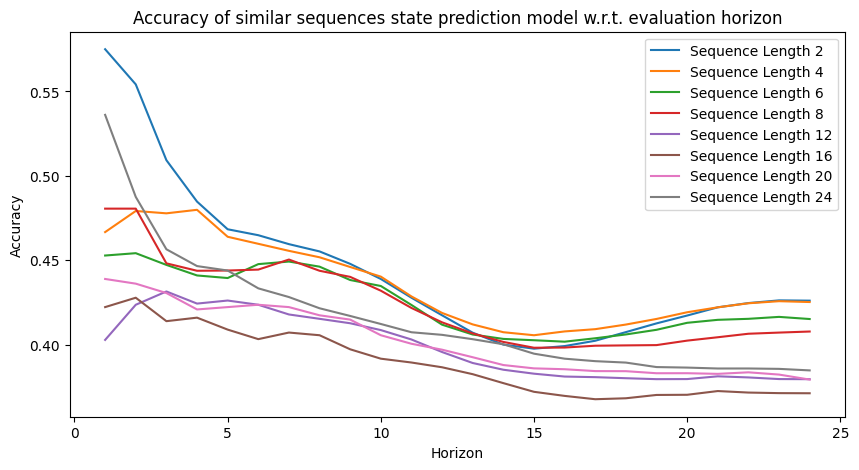

In [204]:
# Generate a very long sequence of states and plot the density of each state with duration inferior to the duration on the x-axis
num_steps = 24
horizons = range(1,25)
sequence_lengths = [2,4,6,8,12,16,20,24]
accuracies = np.zeros((len(sequence_lengths),len(horizons), HOURS_PER_YEAR//num_steps))
for k,sequence_length in enumerate(sequence_lengths):
    for i in range(0,HOURS_PER_YEAR,num_steps):
        most_probable_similar_day = compute_most_probable_similar_sequence_scenario(balancing_states[:HOURS_PER_YEAR],balancing_states[start_index + i - sequence_length:start_index + i], sequence_length)
        
        # Compute accuracy
        for j, horizon in enumerate(horizons):
            accuracy_most_probable_similar_days = np.mean(most_probable_similar_day[:horizon] == balancing_states[start_index + i:start_index + i + horizon])
            accuracies[k][j][i//num_steps] = accuracy_most_probable_similar_days

plt.figure(figsize=(10, 5))
for k,sequence_length in enumerate(sequence_lengths):
    plt.plot(horizons,np.mean(accuracies[k],axis=1),label=f'Sequence Length {sequence_length}')
plt.xlabel('Horizon')
plt.ylabel('Accuracy')
plt.title('Accuracy of similar sequences state prediction model w.r.t. evaluation horizon')
plt.legend()
plt.show()

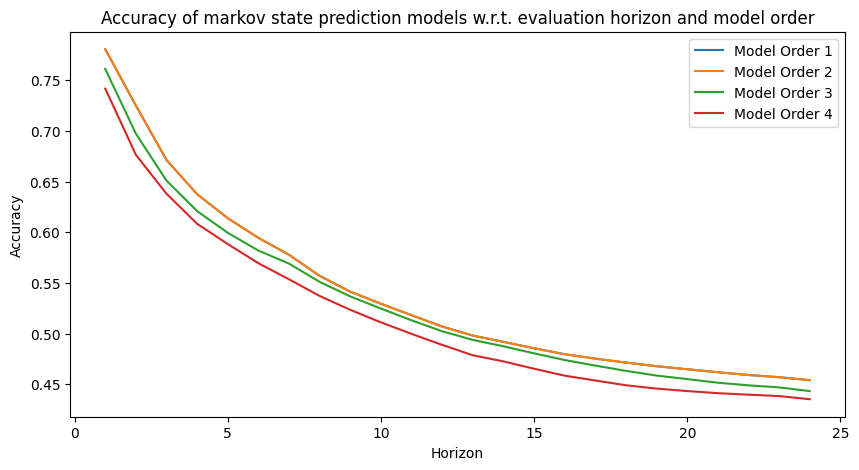

In [205]:
# Generate a very long sequence of states and plot the density of each state with duration inferior to the duration on the x-axis
num_steps = 24
model_orders = [1,2,3,4]
horizons = range(1,25)

accuracies = np.zeros((len(model_orders),len(horizons), HOURS_PER_YEAR//num_steps))
for k,model_order in enumerate(model_orders):
    transition_matrices = build_hour_specific_transition_matrices(balancing_states[:start_index],model_order=model_order)
    for i in range(0,HOURS_PER_YEAR,num_steps):
        states = get_most_probable_states(num_steps, balancing_states[start_index - model_order + i:start_index + i], 0, transition_matrices, model_order)
        
        # Compute accuracy
        for j, horizon in enumerate(horizons):
            accuracy = np.mean(states[:horizon] == balancing_states[start_index + i:start_index + i + horizon])
            accuracies[k][j][i//num_steps] = accuracy

plt.figure(figsize=(10, 5))
for k,model_order in enumerate(model_orders):
    plt.plot(horizons,np.mean(accuracies[k],axis=1),label=f'Model Order {model_order}')
plt.xlabel('Horizon')
plt.ylabel('Accuracy')
plt.title('Accuracy of markov state prediction models w.r.t. evaluation horizon and model order')
plt.legend()
plt.show()

## Rolling Markov Model

In [13]:
def generate_rolling_states_scenario(transition_matrices):
    real_states = balancing_states[start_index - 1:start_index + 23] # Contains the real states (from 0 to 24)
    hour = start_index % 24
    states_sequences_list = []
    accuracies = []
    
    for num_steps in range(24,0,-1):
        states = np.zeros(num_steps, dtype=int)
        prices = np.zeros(num_steps)
        states[0] = np.random.choice(3, p=transition_matrices[hour][real_states[24 - num_steps]])
        for i in range(1, num_steps):
            states[i] = np.random.choice(3, p=transition_matrices[hour][states[i - 1]])
            if state == 0:
                prices[i - 1] = dist_dw.generate(1,verbose=0)
            elif state == 2:
                prices[i - 1] = -dist_up.generate(1,verbose=0)
            hour = (hour + 1) % 24
        accuracy = np.mean(states == balancing_states[(start_index + 24 - num_steps):start_index + 24])
        accuracies.append(accuracy)
        states_sequences_list.append(states)
    return states_sequences_list, accuracies

Accuracies:

[0.4166666666666667, 0.391304347826087, 0.3181818181818182, 0.2857142857142857, 0.35, 0.631578947368421, 0.4444444444444444, 0.23529411764705882, 0.375, 0.4666666666666667, 0.21428571428571427, 0.46153846153846156, 0.5, 0.5454545454545454, 0.6, 0.5555555555555556, 0.75, 0.7142857142857143, 0.5, 0.4, 0.75, 0.6666666666666666, 0.0, 1.0]


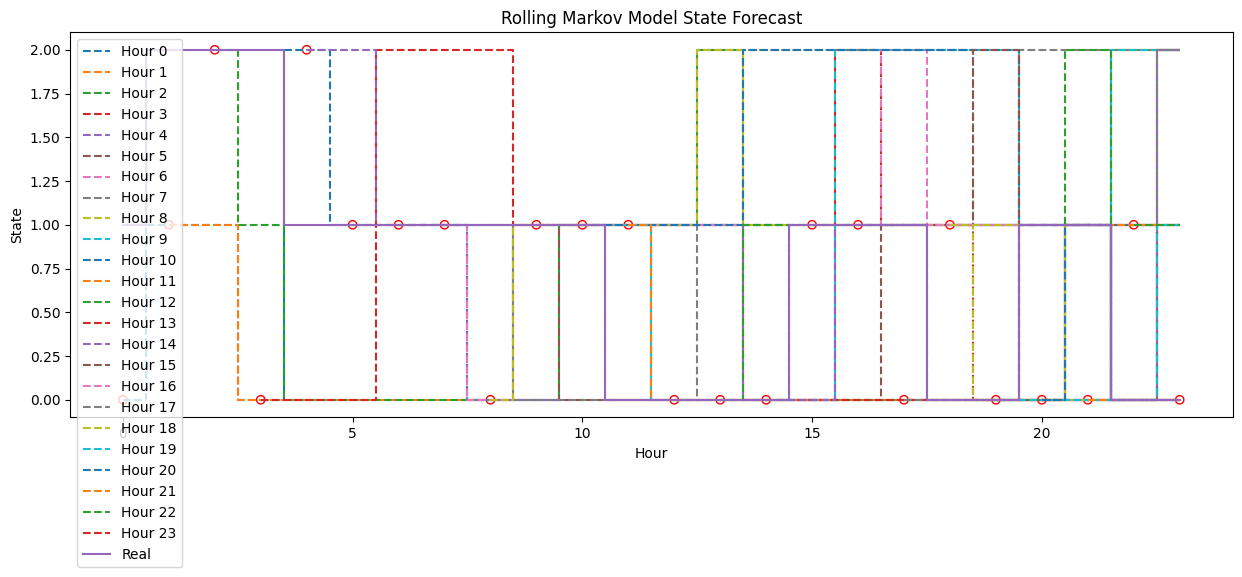

In [244]:
# Generate a scenario of states and prices
states_sequences_list, accuracies = generate_rolling_states_scenario(transition_matrices)

print("Accuracies:\n")
print(accuracies)
# Plot a step plot of the states
plt.figure(figsize=(15, 5))
for i, states in enumerate(states_sequences_list):
    plt.step(range(i, 24), states, where='mid', linestyle='--', label=f'Hour {i}')
    plt.scatter(i,states[0],facecolors='none',edgecolors='red')
plt.step(range(24), balancing_states[start_index:start_index + 24], where='mid', label='Real')
plt.xlabel('Hour')
plt.ylabel('State')
plt.title('Rolling Markov Model State Forecast')
plt.legend()
plt.show()

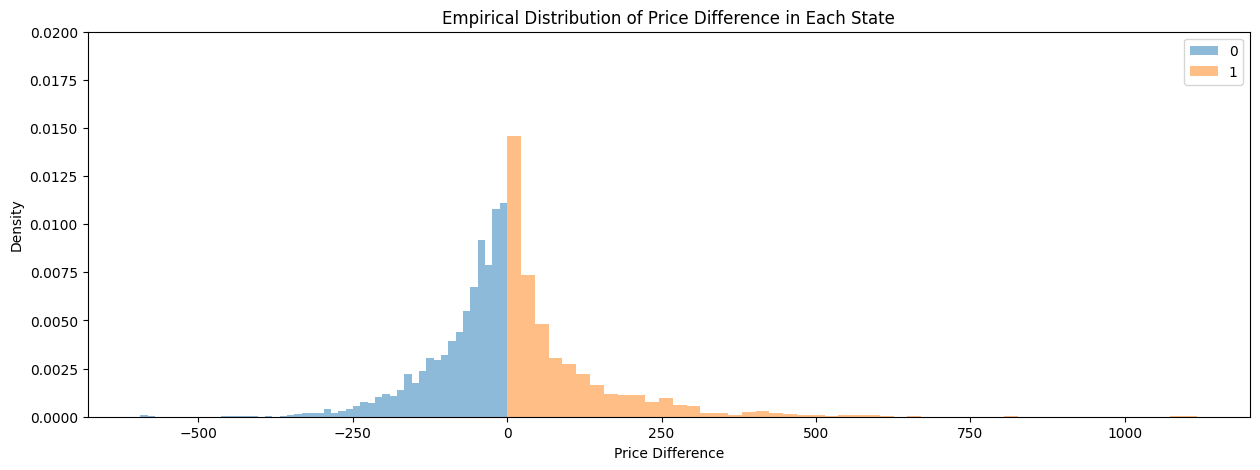

In [14]:
# Plot the empirical distribution of prices diff in each state

# Initialize a dictionary to store the prices diff in each state

prices_diff = {state: [] for state in range(3)}

# Iterate over the data to store the prices diff in each state

for i in range(1, len(balancing_states[:HOURS_PER_YEAR])):
    prices_diff[balancing_states[i]].append(dataframe['prices_SB'][i] - dataframe['forward_RE'][i])
    
# Plot the empirical distribution of prices diff in each state

plt.figure(figsize=(15, 5))
for state, diff in prices_diff.items():
    if state == 1:
        continue
    plt.hist(diff, bins=50, alpha=0.5, label=states[state],density=True)
plt.xlabel('Price Difference')
plt.ylabel('Density')
plt.ylim(0, 0.02)
plt.title('Empirical Distribution of Price Difference in Each State')
plt.legend()
plt.show()

In [15]:
import scipy.stats as stats

dist_up = distfit()
dist_up.fit_transform(np.array(prices_diff[2], dtype=float))

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.000235268] [loc=89.744 scale=115.618]
[distfit] >INFO> [expon     ] [0.0 sec] [RSS: 4.30864e-05] [loc=0.010 scale=89.734]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 1.05495e-05] [loc=-178.121 scale=178.131]
[distfit] >INFO> [dweibull  ] [0.13 sec] [RSS: 0.000125561] [loc=27.870 scale=64.104]
[distfit] >INFO> [t         ] [0.24 sec] [RSS: 0.00013902] [loc=42.086 scale=42.853]
[distfit] >INFO> [genextreme] [0.18 sec] [RSS: 1.28688e-05] [loc=25.848 scale=33.415]
[distfit] >INFO> [gamma     ] [0.10 sec] [RSS: 1.02406e-05] [loc=0.010 scale=141.102]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 5.02094e-06] [loc=-1.744 scale=42.133]
[distfit] >INFO> [beta      ] [0.16 sec] [RSS: 9.99991e-06] [loc=0.010 scale=26400.271]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.000382962] [loc=0.010 scale=1117.570]
[distfit] >INFO> [loggamma  ] [0.04 sec] [RSS: 0.000237982] [loc=-55339.775 scale=6858.0

{'model': {'name': 'lognorm',
  'score': 5.020941661600522e-06,
  'loc': -1.7443880687135056,
  'scale': 42.13304799173995,
  'arg': (1.398827441291866,),
  'params': (1.398827441291866, -1.7443880687135056, 42.13304799173995),
  'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1cc9f7d9fd0>,
  'bootstrap_score': 0,
  'bootstrap_pass': None,
  'color': '#e41a1c',
  'CII_min_alpha': 2.476164375308805,
  'CII_max_alpha': 418.8625719486932},
 'summary':           name     score           loc         scale  \
 0      lognorm  0.000005     -1.744388     42.133048   
 1         beta   0.00001          0.01  26400.270837   
 2        gamma   0.00001          0.01    141.102102   
 3       pareto  0.000011   -178.120593    178.130593   
 4   genextreme  0.000013     25.848478     33.415307   
 5        expon  0.000043          0.01     89.734086   
 6     dweibull  0.000126         27.87     64.104376   
 7            t  0.000139     42.086194     42.853073   
 8         no

[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Lognorm(loc:-1.744388, scale:42.133048)


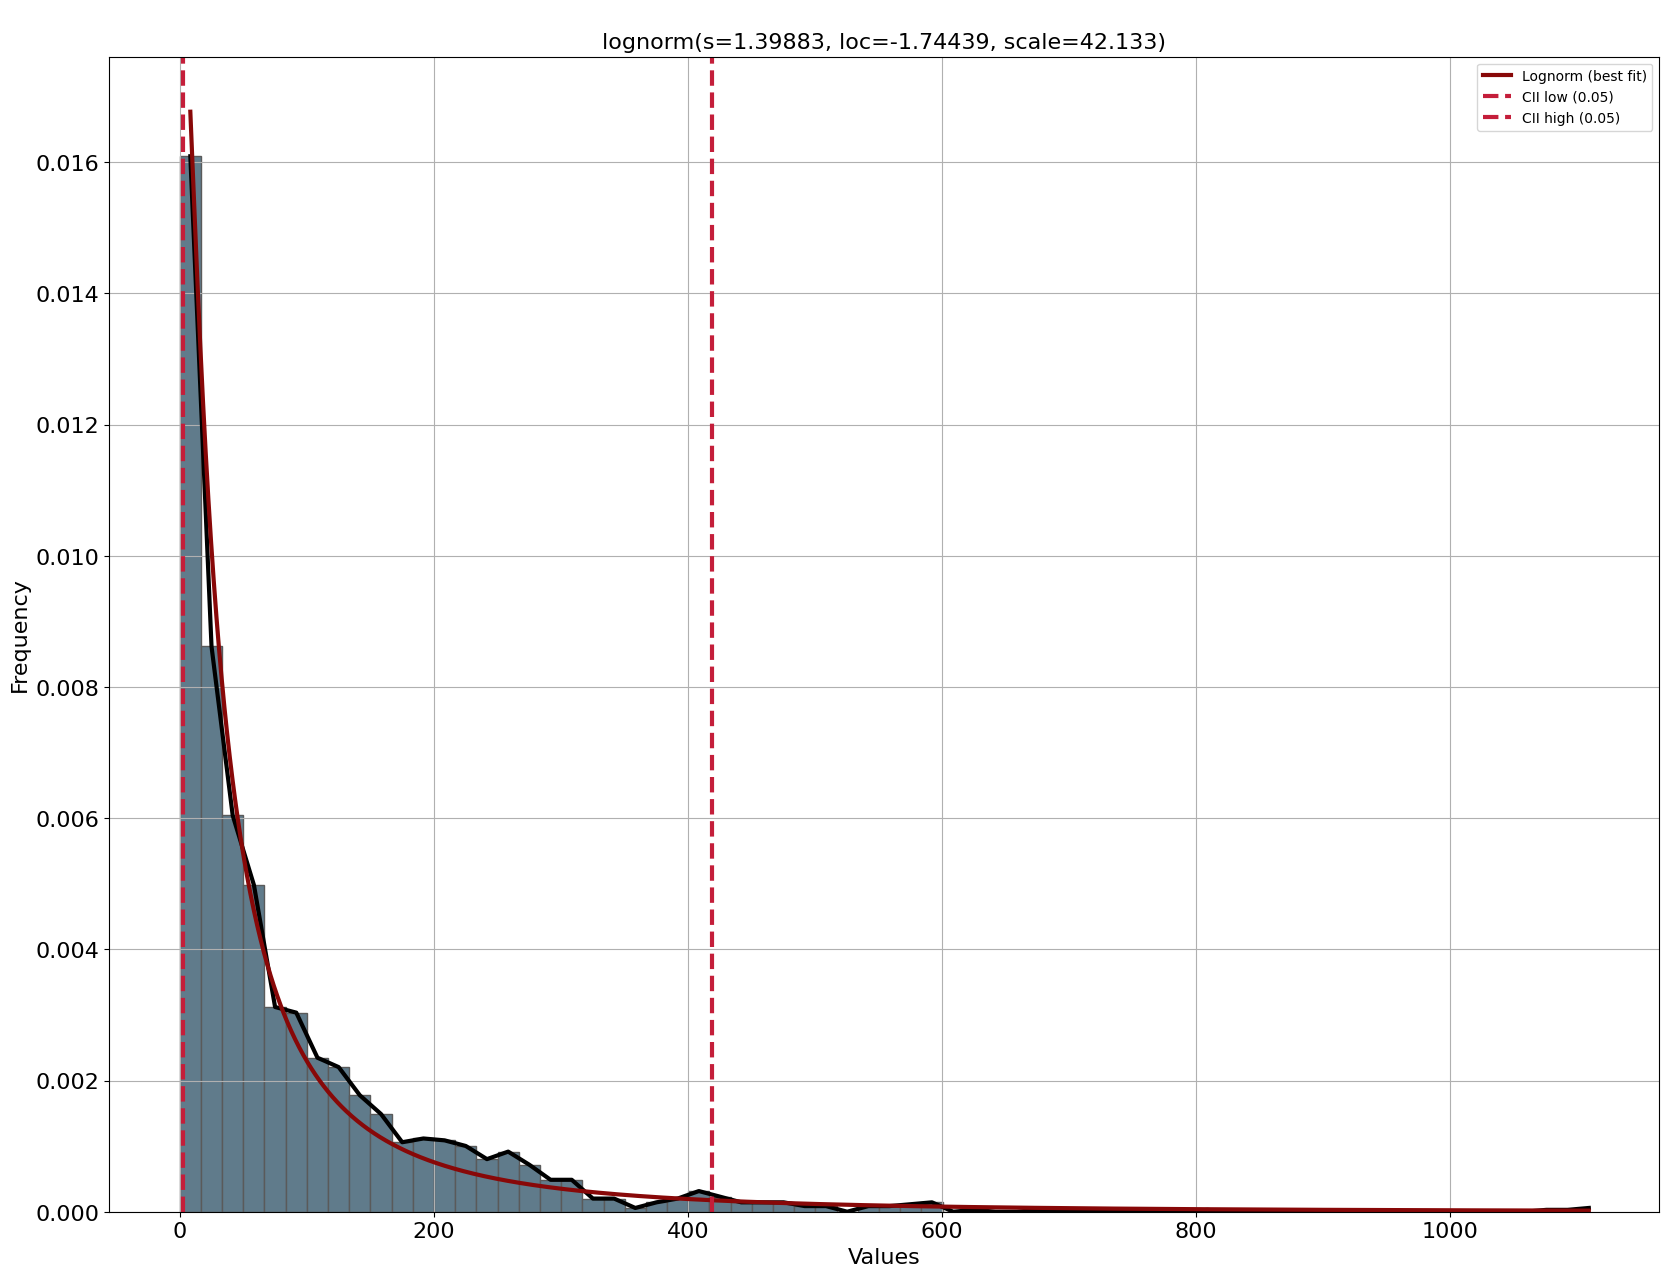

In [16]:
fig, ax = dist_up.plot()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.000155988] [loc=75.935 scale=72.753]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 5.90134e-06] [loc=0.050 scale=75.885]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 5.90134e-06] [loc=-2147483647.950 scale=2147483648.000]
[distfit] >INFO> [dweibull  ] [0.06 sec] [RSS: 0.000111436] [loc=55.608 scale=52.567]
[distfit] >INFO> [t         ] [0.42 sec] [RSS: 0.000111809] [loc=57.407 scale=46.607]
[distfit] >INFO> [genextreme] [0.24 sec] [RSS: 3.15809e-05] [loc=36.365 scale=35.607]
[distfit] >INFO> [gamma     ] [0.04 sec] [RSS: 4.79001e-06] [loc=0.047 scale=70.884]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 1.65578e-05] [loc=-6.207 scale=56.074]
[distfit] >INFO> [beta      ] [0.19 sec] [RSS: 2.10605e-05] [loc=-0.833 scale=12845818730853672.000]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.000403624] [loc=0.050 scale=594.000]
[distfit] >INFO> [loggamma  ] [0.04 sec] [RSS: 0.000161113] [l

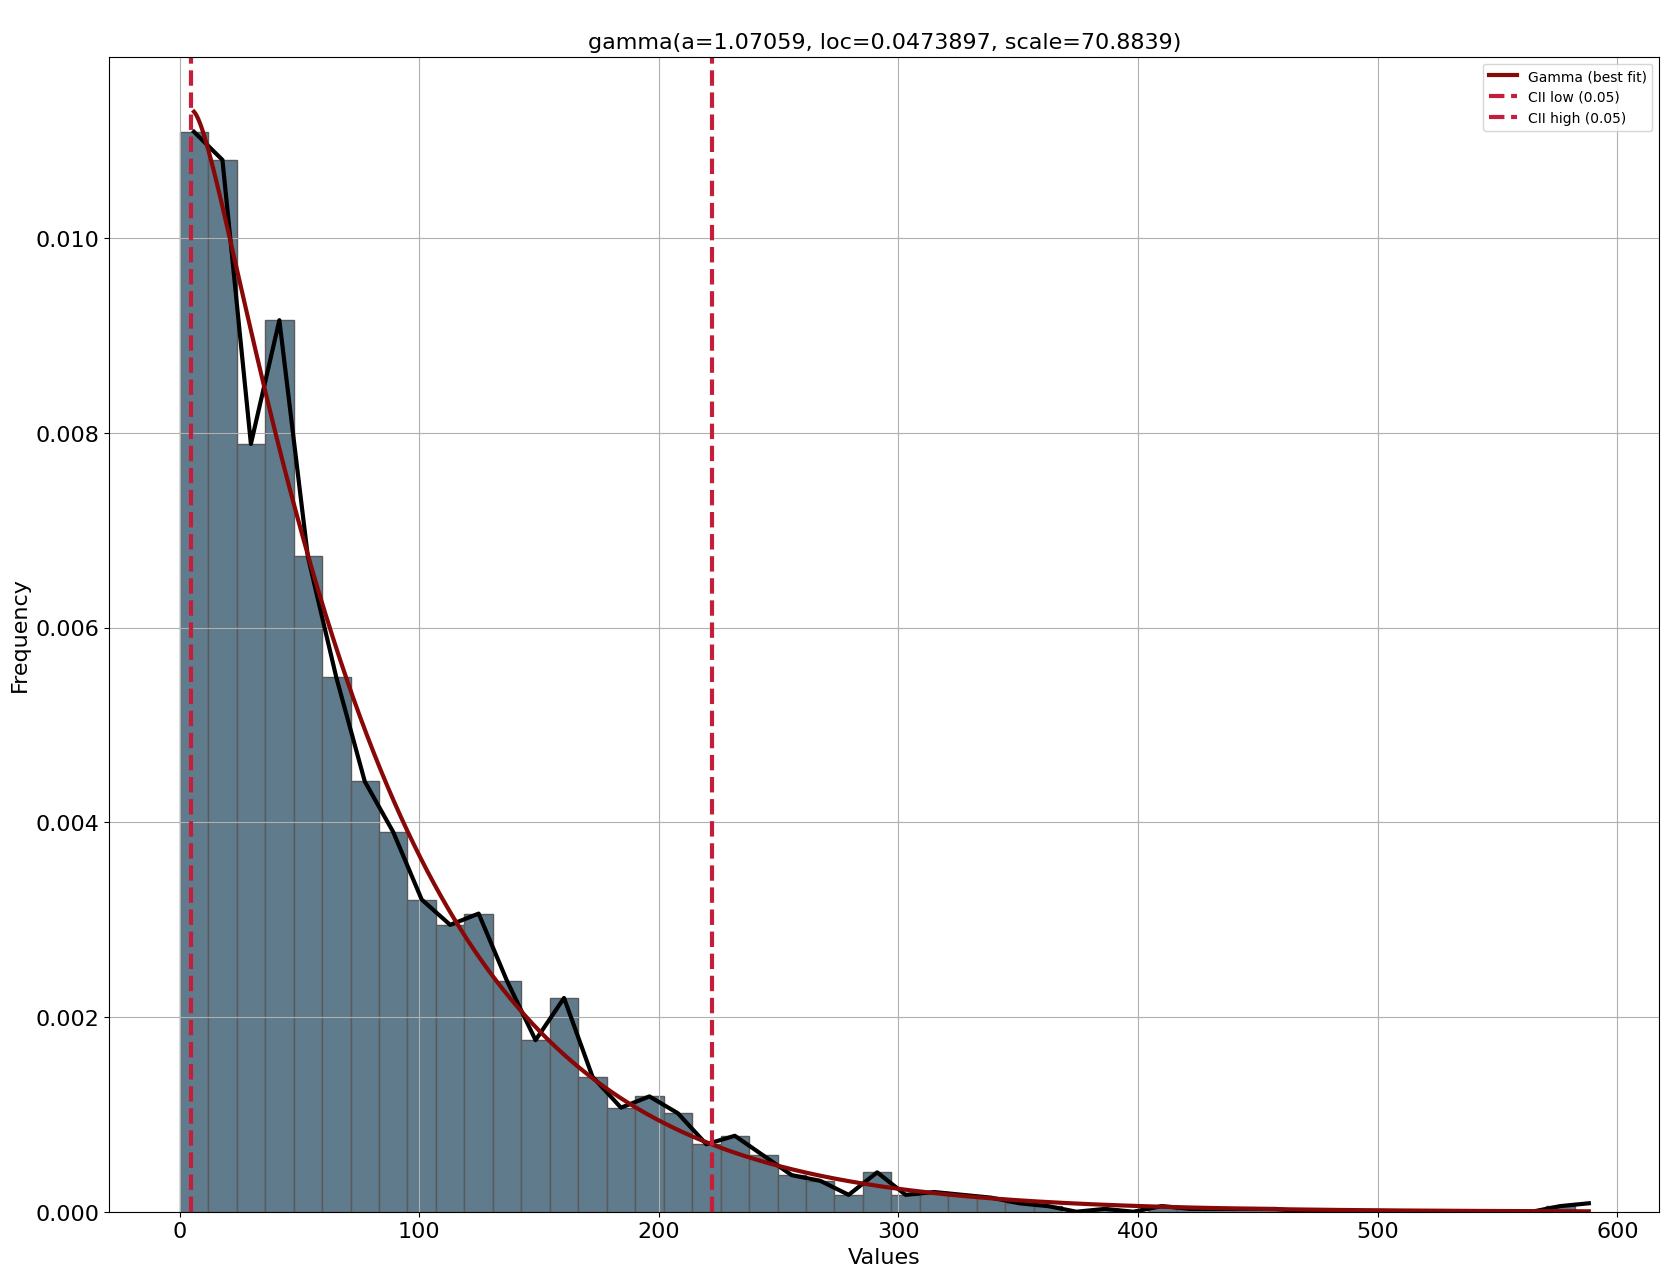

In [17]:
# Fit distributions to each state's data
neg_prices_diff = [-diff for diff in prices_diff[0]]

dist_dw = distfit()
dist_dw.fit_transform(np.array(neg_prices_diff, dtype=float))

fig, ax = dist_dw.plot()

RMSE: 58.2009467596902


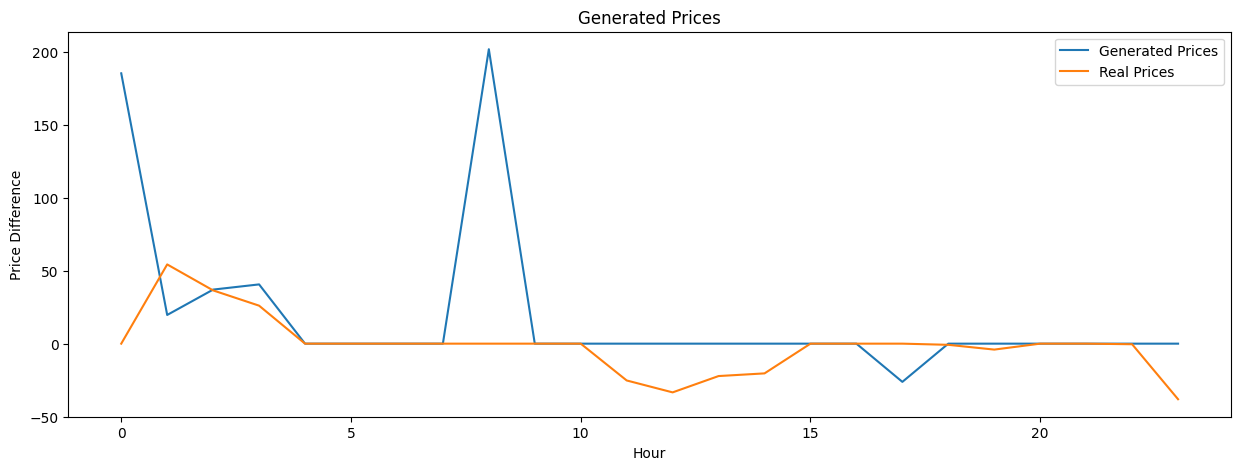

In [19]:
def generate_scenario(num_steps, initial_state, initial_hour, transition_matrices, dist_up, dist_dw):
    states = np.zeros(num_steps + 1, dtype=int)
    states[0] = initial_state
    hour = initial_hour
    prices = np.zeros(num_steps)
    for i in range(1, num_steps + 1):
        state = np.random.choice(3, p=transition_matrices[hour][states[i - 1]])
        states[i] = state
        if state == 0:
            prices[i - 1] = dist_dw.generate(1,verbose=0)
        elif state == 2:
            prices[i - 1] = -dist_up.generate(1,verbose=0)
        hour = (hour + 1) % 24
    return states[1:], prices

def generate_scenarios(num_scenarios, num_steps, initial_state, initial_hour, transition_matrices, dist_up, dist_dw):
    states = np.zeros((num_scenarios, num_steps), dtype=int)
    prices = np.zeros((num_scenarios, num_steps))
    for i in range(num_scenarios):
        states[i], prices[i] = generate_scenario(num_steps, initial_state, initial_hour, transition_matrices, dist_up, dist_dw)
    return states, prices

transition_matrices = build_hour_specific_transition_matrices(balancing_states[:start_index],model_order=1)

# Generate a scenario of states and prices
num_steps = 24
current_state = balancing_states[start_index - 1]
states, prices = generate_scenario(num_steps, current_state, 0, transition_matrices, dist_up, dist_dw)

print("RMSE:", np.sqrt(np.mean((prices - dataframe['price_diff'][start_index:start_index + num_steps].values) ** 2)))

# Plot the generated prices
plt.figure(figsize=(15, 5))
plt.plot(prices,label='Generated Prices')
plt.plot(dataframe['price_diff'][start_index:start_index + num_steps].values,label='Real Prices')
plt.xlabel('Hour')
plt.ylabel('Price Difference')
plt.title('Generated Prices')
plt.legend()
plt.show()

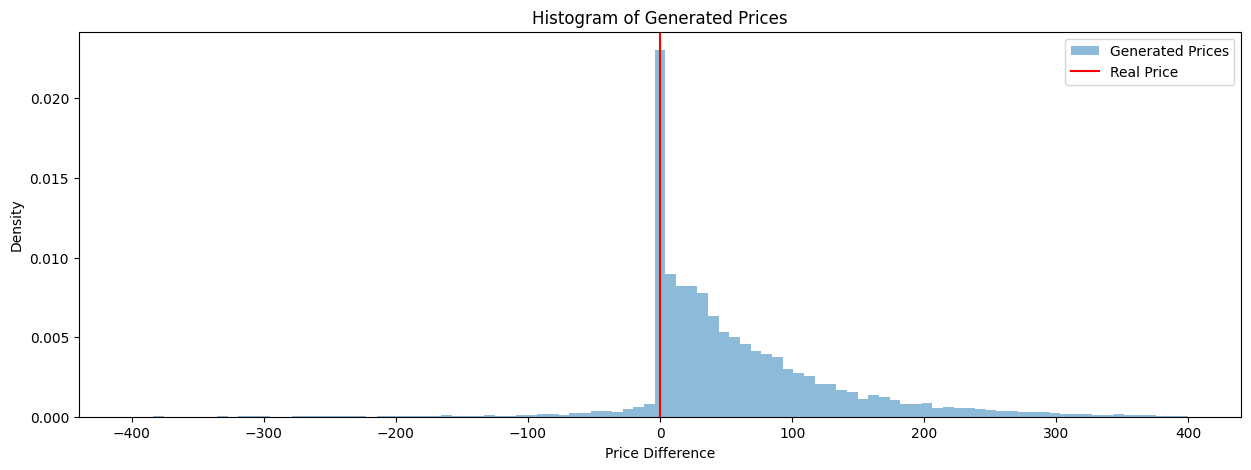

In [20]:
states, prices = generate_scenarios(10000, num_steps, current_state, 0, transition_matrices, dist_up, dist_dw)
# Plot the histogram of the first hour prices
plt.figure(figsize=(15, 5))
first_hour_prices = prices[:, 0]
bins = np.linspace(-400, 400, 100)
plt.hist(first_hour_prices, bins=bins, alpha=0.5, label='Generated Prices',density=True)
plt.axvline(dataframe['price_diff'][start_index], color='red', label='Real Price')
plt.xlabel('Price Difference')
plt.ylabel('Density')
plt.title('Histogram of Generated Prices')
plt.legend()
plt.show()

## MPC based on balancing states

In [21]:
def generate_random_prices_diff_from_states(states, dist_up, dist_dw):
    prices_diff = np.zeros(len(states))
    for i, state in enumerate(states):
        if state == 0:
            prices_diff[i] = -dist_dw.generate(1,verbose=0)
        elif state == 2:
            prices_diff[i] = dist_up.generate(1,verbose=0)
    return prices_diff

In [22]:
def MPC_adjustment_with_naive_balancing_forecasts_markov(data_model, results, verbose=False):
    day_ahead_forecasts =data_model.forecasted_prod

    results = copy.deepcopy(results)

    idx_start = data_model.test_start_index
    idx_end = idx_start + len(results.forward_bids)

    forward_bids = results.forward_bids

    deviations, h_prods, settlements_list, objectives, missing_productions = [], [], [], [], []
    missing_production = daily_count = 0
    
    transition_matrices = build_hour_specific_transition_matrices(balancing_states[:idx_start],model_order=1)

    for t in range(idx_start, idx_end):
        i = t % 24
        if i == 0 and t != idx_start:
            if verbose:
                print(f"Day {t // 24} of {(idx_end - idx_start) // 24} done")
            missing_production = max(data_model.h_min - daily_count, 0)
            daily_count = 0

        forward_bid = forward_bids[t - idx_start]
        hours_left = 24 - i
        
        #Generate states
        states = get_most_probable_states(hours_left, balancing_states[t - 1:t], 0, transition_matrices, model_order=1)
        # print("Accuracy:", np.mean(states == balancing_states[t:t + hours_left]))
        balancing_prices_forecasts = generate_random_prices_diff_from_states(states, dist_up, dist_dw)

        if daily_count < data_model.h_min:
            model = gp.Model('Real Time Adjustment')

            # Variables
            p_adj = model.addMVar(shape=(hours_left,), vtype=GRB.CONTINUOUS, name='p_adj', lb=0.0, ub=data_model.p_h_max)
            settlements = model.addMVar(shape=(hours_left,), vtype=GRB.CONTINUOUS, name='settlements',
                                        lb=-GRB.INFINITY,
                                        ub=GRB.INFINITY)

            model.setObjective(
                compute_objective_fixed_bids_balancing_prices_forecasts(t, idx_start, hours_left, p_adj, settlements,
                                                                        forward_bids, data_model.prices_F,
                                                                        balancing_prices_forecasts),
                GRB.MAXIMIZE)

            # Constraints
            model.addConstr(data_model.h_min <= p_adj.sum() + daily_count, 'Daily Production')

            model.addConstr(settlements[0] == day_ahead_forecasts[0] - forward_bids[t - idx_start] - p_adj[0],
                                'settlement')
            for j in range(1, hours_left):
                k = t + j
                model.addConstr(
                    settlements[j] == day_ahead_forecasts[k] - forward_bids[k - idx_start] - p_adj[j],
                    'settlement')

            model.setParam('OutputFlag', 0)
            model.optimize()

            if model.status != GRB.OPTIMAL:
                if verbose:
                    print(f"Optimization failed at {t}")
                break

            h_adj = np.maximum(0, np.minimum(data_model.p_h_max, p_adj[0].X))

        else:
            h_adj = get_hydro_opt(balancing_prices_forecasts[0], data_model.p_h_max)
        daily_count += h_adj
        settlement = data_model.realized[t] - forward_bid - h_adj

        obj_val = (
                forward_bid * data_model.prices_F[t]
                + PRICE_H * h_adj
                + settlement * data_model.single_balancing_prices[t]
                - missing_production * PENALTY
        )

        deviations.append(data_model.realized[t] - forward_bid)
        h_prods.append(h_adj)
        settlements_list.append(settlement)
        missing_productions.append(missing_production)
        objectives.append(obj_val)
        missing_production = 0

        if verbose:
            print(f"Time {t}:")
            print(f"  Prices: {data_model.single_balancing_prices[t]}, {data_model.prices_F[t]}")
            print(f"  Realized: {data_model.realized[t]}")
            print(f"  Settlement: {settlement}")
            print(f"  Objective Value: {obj_val}")

    results = Result(forward_bids, deviations, h_prods, settlements_list, missing_productions, objectives)
    
    return results

In [23]:
hapd_model = HAPDModel.load('HAPD_model_22_23_hmin50')

results = hapd_model.load_results(ORIGINAL)

results_mpc_markov = MPC_adjustment_with_naive_balancing_forecasts_markov(hapd_model, results)

print("Objective Value:", results.get_total_objective())
print("Objective Value with MPC:", results_mpc_markov.get_total_objective())

Model HAPD_model_22_23_hmin50
Nominal wind: 10
Max wind: 10
Max hydrogen: 10
H min: 50
Number of features: 6
Test start index: 8640
Results loaded successfully.
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-27
Objective Value: 2793273.2589356676
Objective Value with MPC: -190005.38416581048


# ARIMA

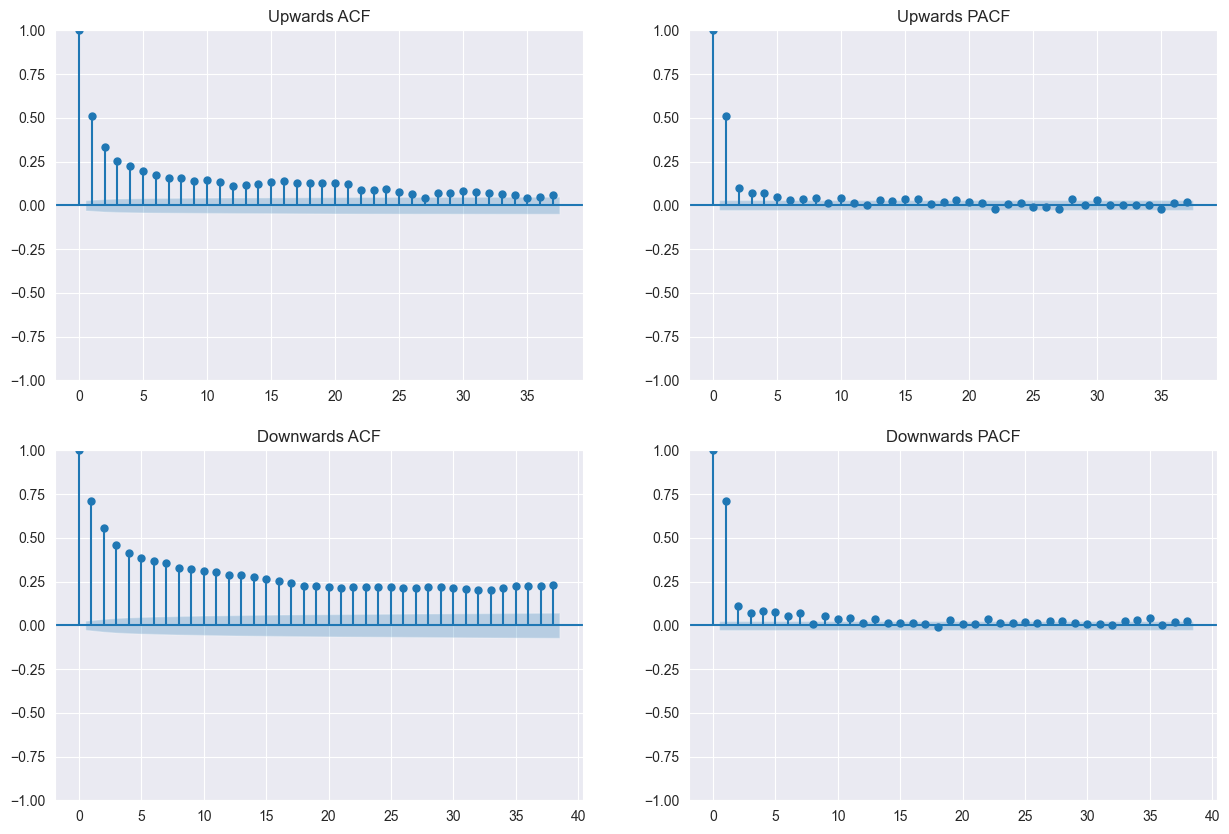

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

epsilon = 0.1
upwards_diff = dataframe['price_diff'][dataframe['balancing_state'] == 2].apply(lambda x: np.log(x + epsilon))
downwards_diff = dataframe['price_diff'][dataframe['balancing_state'] == 0].apply(lambda x: np.log(-x + epsilon))

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plot_acf(upwards_diff, ax=ax[0, 0], title='Upwards ACF')
plot_pacf(upwards_diff, ax=ax[0, 1], title='Upwards PACF')
plot_acf(downwards_diff, ax=ax[1, 0], title='Downwards ACF')
plot_pacf(downwards_diff, ax=ax[1, 1], title='Downwards PACF')
plt.show()

In [12]:
from pmdarima import auto_arima
# Setup arma models for each state
from statsmodels.tsa.statespace.sarimax import SARIMAX

epsilon = 0.1
upwards_diff = dataframe['price_diff'][dataframe['balancing_state'] == 2].apply(lambda x: np.log(x + epsilon))
downwards_diff = dataframe['price_diff'][dataframe['balancing_state'] == 0].apply(lambda x: np.log(-x + epsilon))

#Find the best ARMA parameters for each state
arma_model_up = auto_arima(upwards_diff[-training_length:], seasonal=True, m=24)

arma_model_dw = auto_arima(downwards_diff[-training_length:], seasonal=True, m=24)

# arma_model_up = SARIMAX(upwards_diff[-training_length:], order=(1, 0, 1),seasonal_order=(1, 0, 2, 24))
# arma_model_dw = SARIMAX(downwards_diff[-training_length:], order=(3, 1, 3),seasonal_order=(1, 0, 1, 24))

display(arma_model_up.summary())
display(arma_model_dw.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  720
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 24)   Log Likelihood               -1017.667
Date:                              Wed, 17 Jul 2024   AIC                           2043.334
Time:                                      13:00:44   BIC                           2061.651
Sample:                                           0   HQIC                          2050.405
                                              - 720                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2220      0.076     16.149      0.000       1.074       1.370
ar.L1          0.5557      0.025     22.465      0.000       0.507       0.604
ma.S.L24      -0.0596      0.041     -1.467      0.142      -0.139       0.020
sigma2         0.9884      0.038     26.268      0.000       0.915       1.062
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):               160.97
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.22
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  720
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -855.570
Date:                Wed, 17 Jul 2024   AIC                           1717.140
Time:                        13:00:44   BIC                           1730.877
Sample:                             0   HQIC                          1722.443
                                - 720                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9259      0.054     17.260      0.000       0.821       1.031
ar.L1          0.6643      0.022     29.545      0.000       0.620       0.708
sigma2         0.6299      0.019     33.992      0.000       0.594       0.666
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1442.91
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
# Fit the ARMA models
arma_results_up = arma_model_up.fit(upwards_diff[-training_length:])
arma_results_dw = arma_model_dw.fit(downwards_diff[-training_length:])

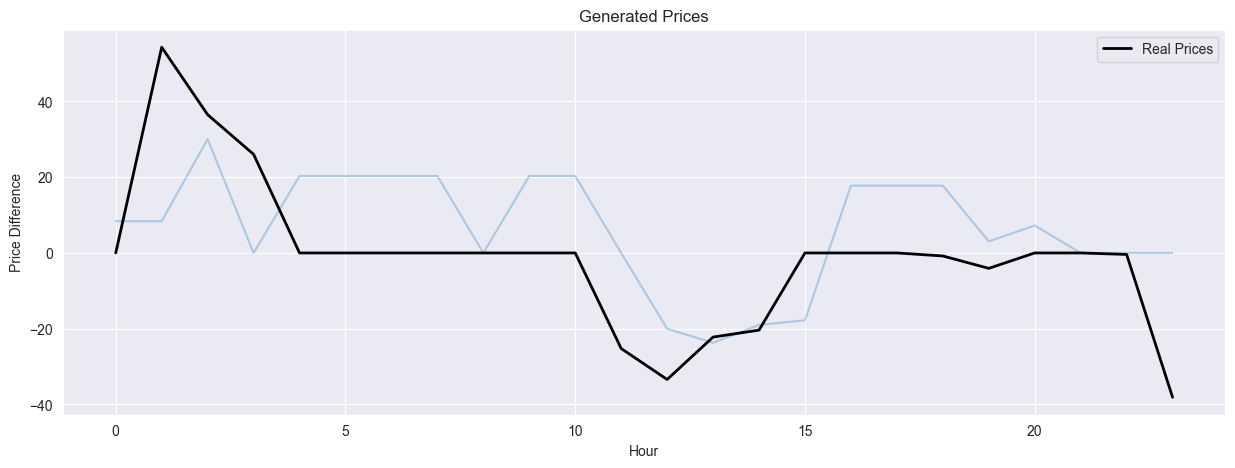

States:

[0 0 0 1 0 0 0 0 1 0 0 1 2 2 2 2 0 0 0 0 0 1 1 1]

Best Accuracy: 0.16666666666666666
RMSE: 19.411357460795813


In [42]:
rmse = []
best_states = []
best_prices = []
lower_bounds = []
upper_bounds = []
best_accuracy = 0
plt.figure(figsize=(15, 5))
for i in range(1):
    arma_results_up = arma_model_up.fit(upwards_diff[-training_length:])
    arma_results_dw = arma_model_dw.fit(downwards_diff[-training_length:])
    # Generate a scenario of states and prices
    num_steps = HOURS_PER_DAY
    current_state = balancing_states[start_index - 1]
    states = generate_states(num_steps, current_state, 0, transition_matrices)
    prices = np.zeros(num_steps)
    for i in range(num_steps):
        if states[i] == 0:  
            result = arma_results_dw.predict(1,return_conf_int=True,alpha=0.05)
            prediction = result[0]
            lower_bound, upper_bound = result[1][0][0], result[1][0][1]
            prices[i] = np.exp(prediction) - epsilon
            lower_bounds.append(np.exp(lower_bound) - epsilon)
            upper_bounds.append(np.exp(upper_bound) - epsilon)
            # Add the price diff to the arima model
        elif states[i] == 2:
            result = arma_results_dw.predict(1,return_conf_int=True,alpha=0.05)
            prediction = result[0]
            lower_bound, upper_bound = result[1][0][0], result[1][0][1]
            prices[i] = -np.exp(prediction) + epsilon
            lower_bounds.append(-np.exp(lower_bound) + epsilon)
            upper_bounds.append(-np.exp(upper_bound) + epsilon)
            # Add the price diff to the arima model
        else:
            lower_bounds.append(0)
            upper_bounds.append(0)
            
        if balancing_states[start_index + i] == 0:
            arma_results_up = arma_results_dw.update(downwards_diff[start_index + i])
        elif balancing_states[start_index + i] == 2:
            arma_results_dw = arma_results_up.update(upwards_diff[start_index + i])
    rmse.append(np.sqrt(np.mean((prices - dataframe['price_diff'][start_index:start_index + num_steps].values) ** 2)))
    accuracy = np.mean(states == balancing_states[start_index:start_index + num_steps])
    plt.plot(prices,alpha=0.3)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_states = states
        best_prices = prices
        
        
plt.plot(dataframe['price_diff'][start_index:start_index + num_steps].values,label='Real Prices', color='black',linewidth=2)
plt.xlabel('Hour')
plt.ylabel('Price Difference')
plt.title('Generated Prices')
plt.legend()
plt.show()

print("States:\n")
print(best_states)
print("\nBest Accuracy:", best_accuracy)
print("RMSE:", np.mean(rmse))

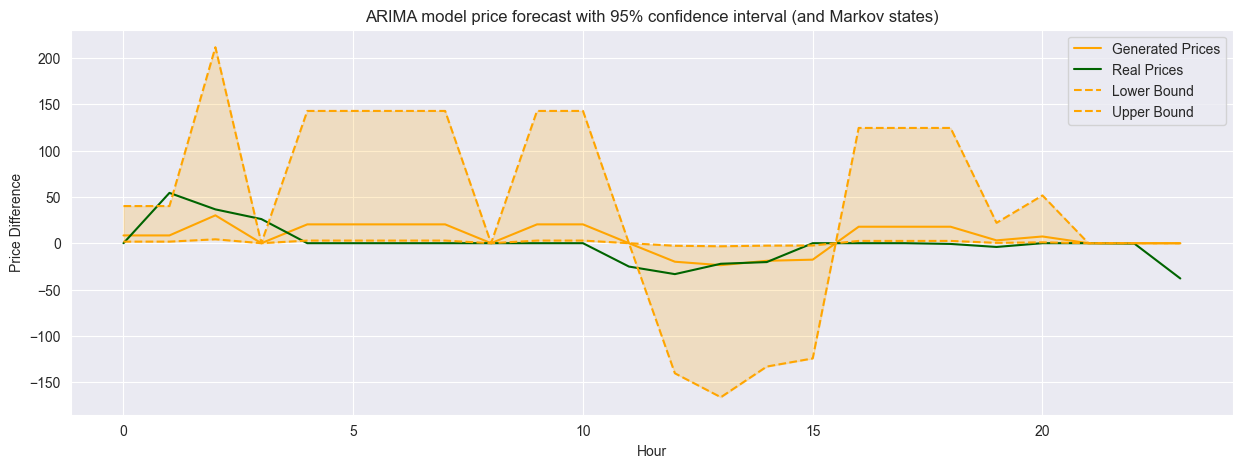

In [43]:
plt.figure(figsize=(15, 5))
plt.plot(best_prices,label='Generated Prices',color='orange')
plt.plot(dataframe['price_diff'][start_index:start_index + num_steps].values,label='Real Prices',color='darkgreen')
plt.plot(lower_bounds,label='Lower Bound',linestyle='--',color='orange')
plt.plot(upper_bounds,label='Upper Bound',linestyle='--',color='orange')
# Fill the area between the lower and upper bounds
plt.fill_between(range(num_steps), lower_bounds, upper_bounds, alpha=0.2, color='orange')
plt.xlabel('Hour')
plt.ylabel('Price Difference')
plt.title('ARIMA model price forecast with 95% confidence interval (and Markov states)')
plt.legend()
plt.show()